# Libraries

In [1]:
from copy import deepcopy

import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.auto import tqdm

# Model

In [2]:
class FlowModel2D(nn.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 2, output_dim: int = 2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.t_emb = nn.Linear(1, hidden_dim)
        self.act1 = torch.nn.GELU()
        self.middle_layer = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = torch.nn.GELU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, t):
        t_emb = self.t_emb(t)
        
        x = self.input_layer(x) + t_emb
        x = self.act1(x)

        x =  self.middle_layer(x) + t_emb
        x = self.act2(x)

        x = self.output_layer(x)

        return x

# Data distribution

In [3]:
n_samples = 500

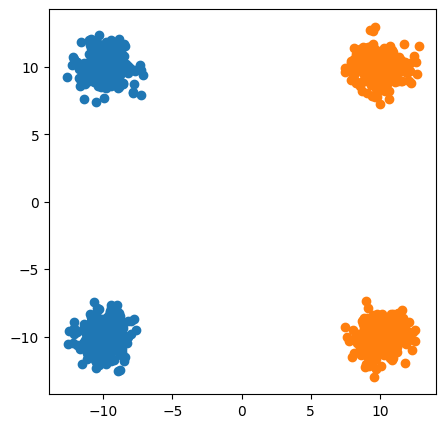

In [4]:
top_left = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0_dataset = torch.cat([top_left, bottom_left])


top_right = torch.randn((n_samples // 2, 2)) + torch.tensor([[+10, 10]])
bottom_right = torch.randn((n_samples // 2, 2)) + torch.tensor([[+10, -10]])

x_1_dataset = torch.cat([top_right, bottom_right])

fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0_dataset[:, 0], x_0_dataset[:, 1])
plt.scatter(x_1_dataset[:, 0], x_1_dataset[:, 1])

# Ordinary Rectified Flow

In [5]:
batch_size = 256
n_epochs = 10_000

## Initialize model

In [6]:
model = FlowModel2D(2, 16, 2)

optimizer = torch.optim.AdamW(
    model.parameters(),
    1e-4,
)

loss_function = torch.nn.MSELoss()

## Let's train

In [7]:
losses = []

model.train()
for i in tqdm(range(n_epochs)):
    x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    x_t = t * x_1 + (1 - t) * x_0
    target = x_1 - x_0

    output = model(x_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/10000 [00:00<?, ?it/s]

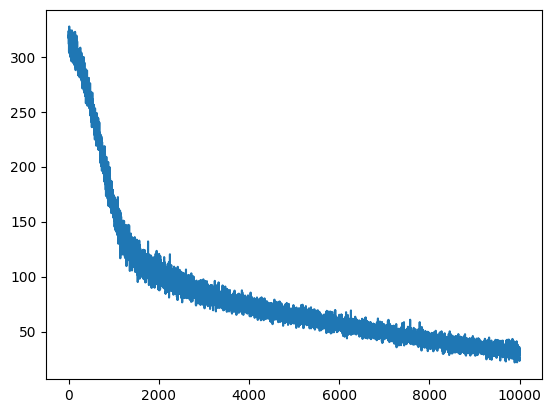

In [8]:
plt.plot(list(range(n_epochs)), losses)

## Inference

In [9]:
model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

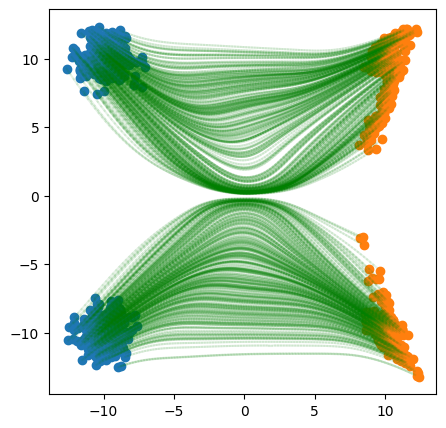

In [10]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step - 1, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

# Now let's add minibatch OT

In [11]:
batch_size = 256
n_epochs = 10_000

In [12]:
model = FlowModel2D(2, 16, 2)

optimizer = torch.optim.AdamW(
    model.parameters(),
    1e-4,
)

loss_function = torch.nn.MSELoss()

In [13]:
import torch


def l2_dist(a: torch.Tensor, b: torch.Tensor):
    flat_a = a.view(a.size(0), -1)
    flat_b = b.view(b.size(0), -1)
    
    # Calculate the squared differences
    squared_diff = (flat_a.unsqueeze(1) - flat_b.unsqueeze(0)).pow(2)
    
    # Sum along the channel dimension
    sum_squared_diff = squared_diff.sum(dim=2)
    
    # Take the square root to get Euclidean distances
    distance_matrix = sum_squared_diff.sqrt()
    
    return distance_matrix

## Train

In [14]:
losses = []

model.train()
for i in tqdm(range(n_epochs)):
    x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]

    dist = l2_dist(x_0, x_1)
    plan = scipy.optimize.linear_sum_assignment(dist)[1]
    x_0 = x_0[plan]
    
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    x_t = t * x_1 + (1 - t) * x_0
    target = x_1 - x_0

    output = model(x_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/10000 [00:00<?, ?it/s]

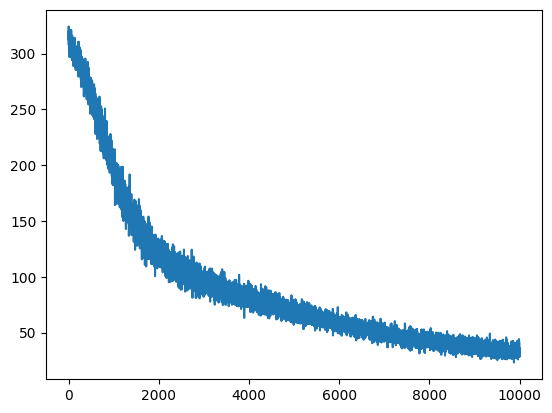

In [15]:
plt.plot(list(range(n_epochs)), losses)

In [16]:
model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

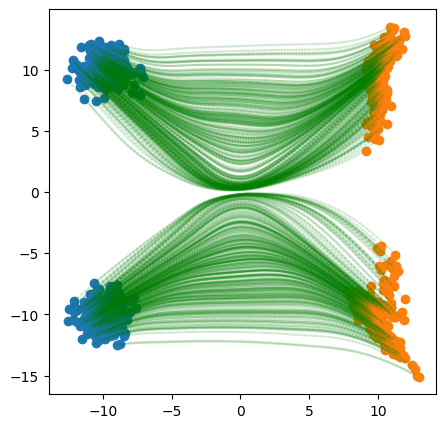

In [17]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step - 1, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

# Reflow 2

In [18]:
batch_size = 256
n_epochs = 1_000

In [19]:
teacher_model = deepcopy(model)
student_model = deepcopy(model)

optimizer = torch.optim.AdamW(
    student_model.parameters(),
    1e-4,
)

loss_function = torch.nn.MSELoss()

In [20]:
def teacher_sample_z_1(model, x_0):
    x_t = x_0.clone()

    NFE = 100
    h = 1 / NFE
    
    for t in torch.linspace(0, 1, NFE):
        t = torch.full(size=(x_0.shape[0], 1), fill_value=t)
        
        with torch.no_grad():
            output = model(x_t, t)
    
        x_t = x_t + h * output
    
    return x_t

In [21]:
losses = []

model.train()
for i in tqdm(range(n_epochs)):
    z_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    z_1 = teacher_sample_z_1(teacher_model, z_0)
    
    
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    z_t = t * z_1 + (1 - t) * z_0
    target = z_1 - z_0

    output = student_model(z_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

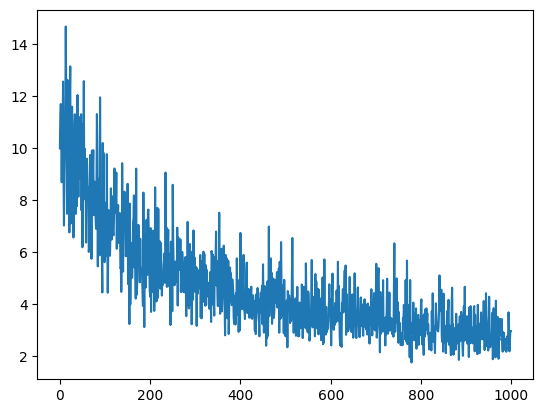

In [22]:
plt.plot(list(range(n_epochs)), losses)

In [23]:
model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = student_model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

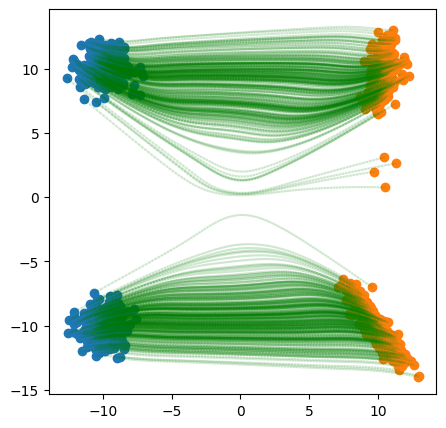

In [24]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()